# Predicting Newsletter Subscription on a Minecraft Research Server

Github Repo: https://github.com/Parkryan0128/DSCI100_Project

Linkedin: https://www.linkedin.com/in/ryanpark0128/

**Background**
The PLAI research group at the University of British Columbia operates a custom Minecraft server to study characteristics of people who play on their server.
Some of these players choose to subscribe to game-related newsletter. From a research operations standpoint, newsletter subscribers are valuable: they tend to return, generate more data, and can be recruited for follow-up studies at low cost. Knowing which demographic traits and in-game behaviours drive the decision to subscribe helps the research team (1) focus recruitment on the most receptive audiences and (2) design targeted retention campaigns that nudge undecided players toward deeper involvement.

**Question**
Which player characteristics and play-style metrics best predict whether a participant subscribes to game-related newsletter?
By modelling newsletter subscription as a binary outcome, we aim to identify measurable features—such as total play time, age, preferred play hours, or self-reported experience level—that distinguish subscribers from non-subscribers.

**Data Description**
This analysis combines information from two datasets:

players.csv – one row per player (n ≈ 196).
variables:
- subscribe – target flag indicating newsletter opt-in
- experience – Pro, Veteran, Regular, etc.
- gender - Self-identified gender category 
- age - Player’s age in years
- hashedEmail - Anonymised unique identifier
- name - Name of the player
- played hours - Cumulative play time for the player

sessions.csv – one row per game session (≈ 1 535 records).
variables:
- hashedEmail - Anonymised unique identifier
- start_time - Session start in local server time
- end_time - Session end
- original_start_time - Unix epoch milliseconds marking session start
- original_end_time - Unix epoch milliseconds marking session end

Session records will be aggregated per player to derive behavioural predictors—e.g., total minutes played, mean session length, weekday/weekend ratio, and most frequent hour-of-day. After merging with players.csv, the resulting data will be used to build a model to quantify which factors most influence newsletter subscription.

Since we are predicting a categorical variable, we will train a classification model and evaluate its performance.

**Load Packages**

In [27]:
### Run this cell before continuing. 
library(tidyverse) # dplyr, ggplot2, ..etc
library(lubridate) # extracting dates & times.
library(tidymodels) # modeling and machine-learning workflows (recipes, resampling, tuning).

**load raw data**

In [28]:
players  <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

head(players) # first 6 rows
head(sessions) # first 6 rows

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


Prepare target variable for classification. Tidymodels expects the outcome to be a factor. Convert `subscribe` variable to the factor, so that recipes/models treat `subscribe` as a categorical class.


In [29]:
# convert the subscribe variable to factor
players <- players |>
    mutate(subscribe = as_factor(subscribe))

**Sanity-check**: confirm one row == one player. We expect `hashedEmail` to be unique in players.csv. If every player appears exactly once, the total row count should equal the number of distinct hashedEmail values.

In [30]:
# each row is unique
nrow(players)
n_distinct(players$hashedEmail)

[1] 196

[1] 196

**Class balance check**: Before modelling we quantify proportion of subscription. These numbers can be used as baseline for our evaluation of the model.

In [31]:
num_obs <- nrow(players)  # total players
players |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )


subscribe,count,percentage
<fct>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


To transform the raw session data into predictors, we first parse the character timestamps in start_time and end_time into proper date-time objects, then compute each session’s length in minutes. From the start time we extract the calendar weekday and the 24-hour clock hour to flag when play occurred. We then collapse the data from “one row per session” to “one row per player,” producing five behavioural features: total minutes played (`tot_minutes`), number of sessions (`n_sessions`), average session length (`avg_session_min`), the proportion of play that occurs in the evening window 18:00–23:59 (`evening_prop`), and the proportion of play that falls on weekends (`weekend_prop`). These aggregated variables capture overall engagement, visit frequency, and temporal preferences—information that is both interpretable and suitable for use as numeric predictors in the subscription classifier.

In [32]:
sessions_mutate <- sessions|>
  mutate(
    start_dt = dmy_hm(start_time, tz = "UTC"),
    end_dt   = dmy_hm(end_time,   tz = "UTC"),
    dur_min  = as.numeric(difftime(end_dt, start_dt, units = "mins")),
    wday_lbl = wday(start_dt, label = TRUE),
    hour24   = hour(start_dt)
  )


In [33]:
sessions_processed <- sessions_mutate |>
  group_by(hashedEmail) |> 
  summarise(
    tot_minutes   = sum(dur_min,   na.rm = TRUE),
    n_sessions    = n(),                              # simple count
    avg_session_min   = mean(dur_min,  na.rm = TRUE),
    evening_prop  = mean(hour24 %in% 18:23),          # 0-1 ratio
    weekend_prop  = mean(wday_lbl %in% c("Sat","Sun"))
  )

After wrangling sessions data, we performed an inner_join on hashedEmail to combine players.csv with the sessions data. This join retains only those users who actually logged at least one session. A quick audit confirms the result: out of 196 registered players, only 125 distinct hashedEmail values appear in sessions.csv, so the merged combined_data contains 125 rows—approximately two-thirds of the original data. We then removed the legacy variable `played_hours` because it is a coarse, one-decimal approximation of total play time; our newly derived `tot_minutes` captures the same information with minute-level precision and makes played_hours redundant.

In [34]:
combined_data <- players |>
  inner_join(sessions_processed, by = "hashedEmail") |>
  mutate(
    subscribe = as.factor(subscribe),           
  )

In [35]:
#checks how many hashedEmail created at least one session. Matches data in combined_data
nrow(combined_data)
n_distinct(sessions$hashedEmail)
nrow(players)


combined_data <- combined_data |> select(-played_hours)
head(combined_data)


[1] 125

[1] 125

[1] 196

experience,subscribe,hashedEmail,name,gender,Age,tot_minutes,n_sessions,avg_session_min,evening_prop,weekend_prop
<chr>,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,Morgan,Male,9,2019,27,74.77778,0.5185185,0.5555556
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,Christian,Male,17,255,3,85.00000,0.3333333,0.0000000
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,Blake,Male,17,5,1,5.00000,0.0000000,0.0000000
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,Flora,Female,21,50,1,50.00000,0.0000000,1.0000000
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,Kylie,Male,21,9,1,9.00000,0.0000000,0.0000000
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,Emerson,Male,21,5,1,5.00000,0.0000000,1.0000000


Among our predictors, `avg_session_min` immediately catches attention: average session length is an obvious variable for player engagement, and sustained engagement is precisely a factor that leads to subscription. To get a rough, visual sense of how informative this variable might be, I created a density plot of `avg_session_min`, split by `subscribe` status, as a first exploratory check before formal modelling.


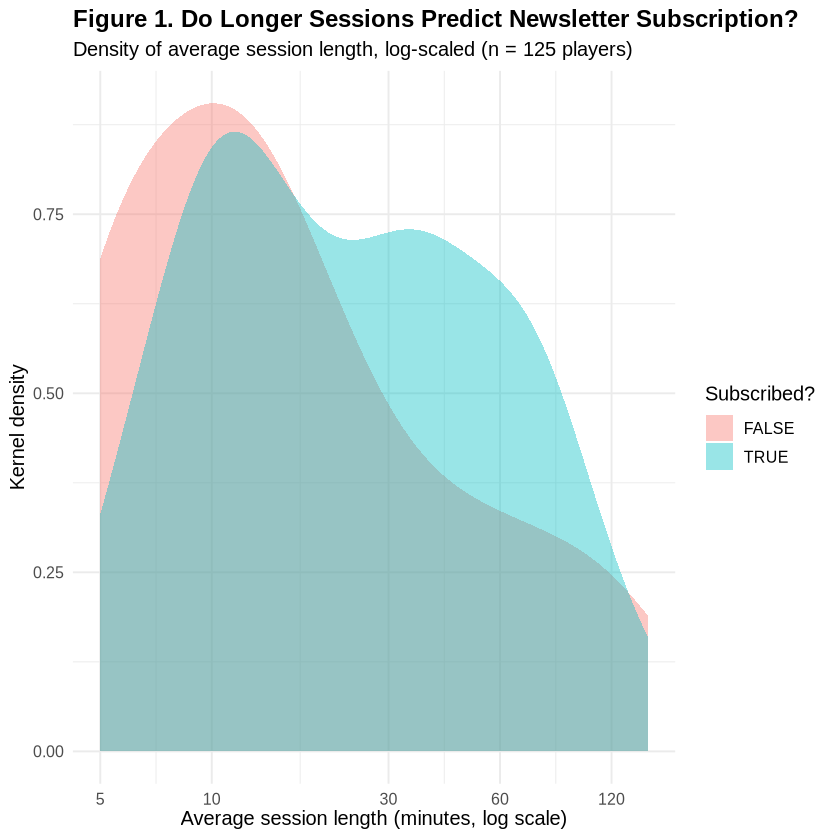

In [36]:
ggplot(combined_data, aes(avg_session_min, fill = subscribe)) +
  geom_density(alpha = 0.4, colour = NA) +
  scale_x_log10(
    labels = label_number(scale_cut = cut_short_scale()),
    breaks = c(1, 5, 10, 30, 60, 120)
  ) +
  theme_minimal(base_size = 12) +
  labs(
    title = "Figure 1. Do Longer Sessions Predict Newsletter Subscription?",
    subtitle = "Density of average session length, log-scaled (n = 125 players)",
    x = "Average session length (minutes, log scale)",
    y = "Kernel density",
    fill = "Subscribed?"
  ) +
  theme(
    plot.title      = element_text(face = "bold"),
    legend.position = "right"
  )

The density plot of average session length (log-scaled minutes) by subscription status reveals an informative pattern. Subscribers’ curve (blue) is shifted modestly to the right: their peak lies around 15–20 minutes, and the distribution decays gradually, indicating they tend to play steadily longer sessions. Non-subscribers (pink) cluster much more tightly at the very short end—sub-10-minute “dip-in” sessions dominate their profile—and only a small tail extends beyond an hour. Despite that shift, the two curves **overlap** heavily through the first 30 minutes.

Longer sessions are characteristic of players who opt in to the newsletter, but the separation is **not sharp enough** to identify individual non-subscribers reliably; many subscribers also log brief sessions, and a few non-subscribers run marathon sessions.

Another pair of candidate predictors are `n_sessions` (how often a player logs in) and `tot_minutes` (cumulative time spent on the server). Because both variables capture different aspect of play intensity (frequency versus duration), I first wanted to see whether they exhibit any clear relationship that could inform feature selection or transformation. To get a quick visual read, I created a scatter plot of total minutes played versus number of sessions, with points coloured by subscription status.

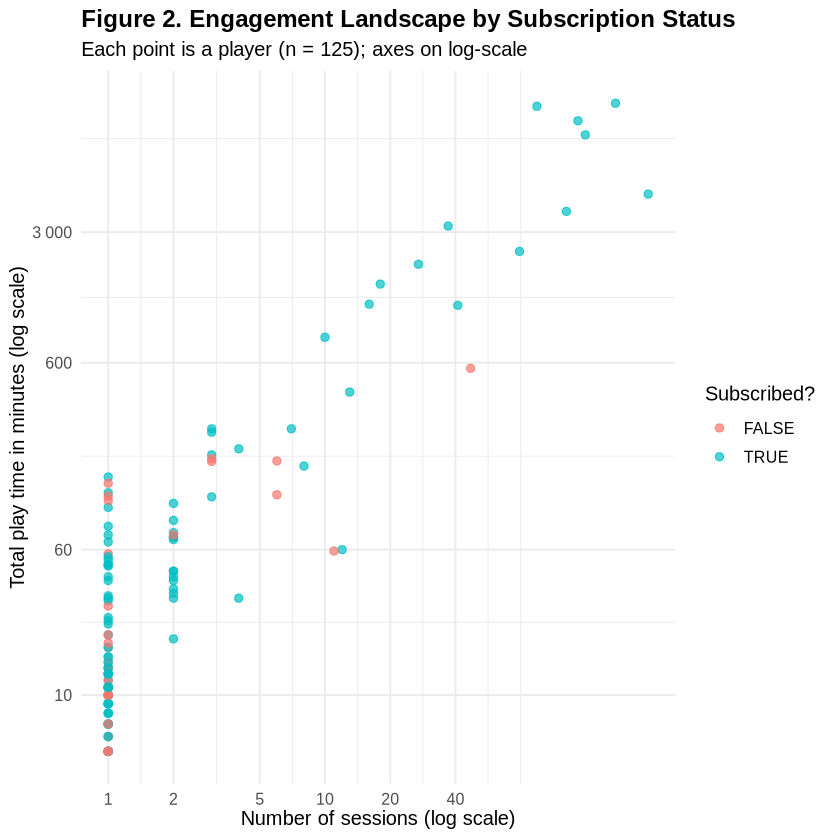

In [37]:
ggplot(combined_data,
       aes(x = n_sessions,
           y = tot_minutes,
           colour = subscribe)) +
  geom_point(alpha = 0.7, size = 2) +
  scale_x_log10(
    breaks = c(1, 2, 5, 10, 20, 40),
    labels = c("1","2","5","10","20","40")
  ) +
  scale_y_log10(
    breaks = c(1, 10, 60, 600, 3000),
    labels = c("1", "10", "60", "600", "3 000")
  ) +
  labs(
    title    = "Figure 2. Engagement Landscape by Subscription Status",
    subtitle = "Each point is a player (n = 125); axes on log-scale",
    x        = "Number of sessions (log scale)",
    y        = "Total play time in minutes (log scale)",
    colour   = "Subscribed?"
  ) +
  theme_minimal(base_size = 12) +
  theme(plot.title = element_text(face = "bold"))

**Figure 2** reveals a clear relationship between overall engagement and newsletter subscription. When total play time is plotted against the number of sessions (both axes log-scaled), subscribers spread out along a rising diagonal: the more often they log in, the more minutes they accumulate. Every player who appears in the upperright portion of the chart has subscribed, suggesting that frequent, long-running play virtually guarantees an opt-in. Non-subscribers (pink) are largely confined to the lower-left corner: one or two brief sessions amounting to less than an hour of play. Only two non-subscriber points venture above 100 total minutes, underscoring how rare sustained engagement is among players who decline the newsletter. Where the two colours overlap at very low engagement levels, subscription status is indistinguishable, implying that **casual play alone does not explain the decision**. Taken together, the plot indicates that depth of engagements is the primary behavioural difference between subscribers and non-subscribers.

Now, It is time to train model to make prediction. I trained a k nearest neighbour classifier for every potential predictor to see which single feature carries the most predictive weight. First, the data are stratified **70 / 30** into training and test sets so that final accuracy is judged on rows the model has never seen. For each candidate variable I build a appropriate recipe and run **5-fold cross-validation** on the training split, tuning k over the odd numbers **1 – 25**. The neighbour count that maximises CV accuracy is then fixed, the model is refit on the full mini-training set, and its accuracy is evaluated on the untouched test subset. All results are collected in a tibble and sorted, giving a fair, like-for-like ranking of which single predictor is most informative for subscription.

In [38]:
set.seed(42)
data_split <- initial_split(combined_data, prop = 0.70, strata = subscribe)
train_data <- training(data_split)
test_data  <- testing(data_split)

vars      <- setdiff(names(train_data), c("subscribe", "hashedEmail", "name"))
k_grid    <- tibble(neighbors = seq(1, 25, by = 2))
base_spec <- nearest_neighbor(neighbors = tune()) |>
             set_engine("kknn") |>
             set_mode("classification")

one_var_knn_acc <- function(var){

    mini_train <- train_data |> select(subscribe, all_of(var))
    mini_test  <-  test_data |> select(subscribe, all_of(var))

    rec <- recipe(subscribe ~ ., data = mini_train) |>
           step_impute_median(all_numeric_predictors()) |>
           step_normalize(all_numeric_predictors()) |>
           step_other(all_nominal_predictors(), threshold = 0.02) |>
           step_novel(all_nominal_predictors()) |>
           step_dummy(all_nominal_predictors(), one_hot = TRUE) |>
           step_zv(all_predictors())

    mini_folds <- vfold_cv(mini_train, v = 5, strata = subscribe)

    tune_safe <- safely(function() {
        workflow() |>
            add_recipe(rec) |>
            add_model(base_spec) |>
            tune_grid(resamples = mini_folds,
                grid      = k_grid,
                metrics   = metric_set(accuracy))
    })

  tuned_res <- tune_safe()
  if (!is.null(tuned_res$error)) {
    return(tibble(variable = var, accuracy = NA_real_))
  }

  best_k <- tuned_res$result |>
    select_best(metric = "accuracy") |>
    pluck("neighbors")

  final_spec <- nearest_neighbor(neighbors = best_k) |>
                set_engine("kknn") |>
                set_mode("classification")

  fit <- workflow() |>
         add_recipe(rec) |>
         add_model(final_spec) |>
         fit(mini_train)

  acc <- accuracy(
           bind_cols(predict(fit, mini_test),
                     mini_test |> select(subscribe)),
           truth = subscribe, estimate = .pred_class
         ) |> pull(.estimate)
    
  print(paste("Confusion matrix for: ", var))
  conf_mat(bind_cols(predict(fit, mini_test),
                     mini_test |> select(subscribe)),
           truth = subscribe, estimate = .pred_class) |> print()

  tibble(variable = var, accuracy = acc)
}

scores <- map_dfr(vars, one_var_knn_acc) |>
          arrange(desc(accuracy))

[1] "Confusion matrix for:  experience"
          Truth
Prediction FALSE TRUE
     FALSE     1    4
     TRUE      9   24
[1] "Confusion matrix for:  gender"
          Truth
Prediction FALSE TRUE
     FALSE     7   21
     TRUE      3    7
[1] "Confusion matrix for:  Age"
          Truth
Prediction FALSE TRUE
     FALSE     4   11
     TRUE      6   17
[1] "Confusion matrix for:  tot_minutes"
          Truth
Prediction FALSE TRUE
     FALSE     1    3
     TRUE      9   25
[1] "Confusion matrix for:  n_sessions"
          Truth
Prediction FALSE TRUE
     FALSE     8   20
     TRUE      2    8
[1] "Confusion matrix for:  avg_session_min"
          Truth
Prediction FALSE TRUE
     FALSE     2    3
     TRUE      8   25
[1] "Confusion matrix for:  evening_prop"
          Truth
Prediction FALSE TRUE
     FALSE     5   14
     TRUE      5   14
[1] "Confusion matrix for:  weekend_prop"
          Truth
Prediction FALSE TRUE
     FALSE     6   14
     TRUE      4   14


In addition to recording the accuracy for each single‐predictor model, I printed its **confusion matrix** to confirm that it aligns with the accuracy. Evaluating the confusion matrix confirms that the higher ranked variables in accuracy (especially `avg_session_min`) performs slightly better than the lower ranked variables. Inspecting these matrices safeguards against choosing a feature that looks good numerically but delivers an imbalanced or practically useless decision boundary.

In [39]:
print(scores)

# A tibble: 8 × 2
  variable        accuracy
  <chr>              <dbl>
1 avg_session_min    0.711
2 tot_minutes        0.684
3 experience         0.658
4 Age                0.553
5 weekend_prop       0.526
6 evening_prop       0.5  
7 n_sessions         0.421
8 gender             0.368


The table above ranks each single predictor k-NN model by its accuracy (highest → lowest). `avg_session_min` and `tot_minutes` clearly outperform the rest, achieving ~71 % and ~68 % accuracy, respectively. Demographic features such as experience and Age offer moderate predictive power, while temporal ratios (weekend_prop, evening_prop) and simple frequency counts (n_sessions, gender) trail well behind.

To make the ranking easier to digest, I translated the accuracy table into the horizontal bar chart below. Each bar shows the best 5-fold cross-validated accuracy (after tuning k) that a single variable can achieve on its own. The visual confirms the numeric takeaway: `avg_session_min` sits ahead of the pack, demographic features provide moderate lift, and simple frequency or time-of-week ratios offer little standalone predictive power.

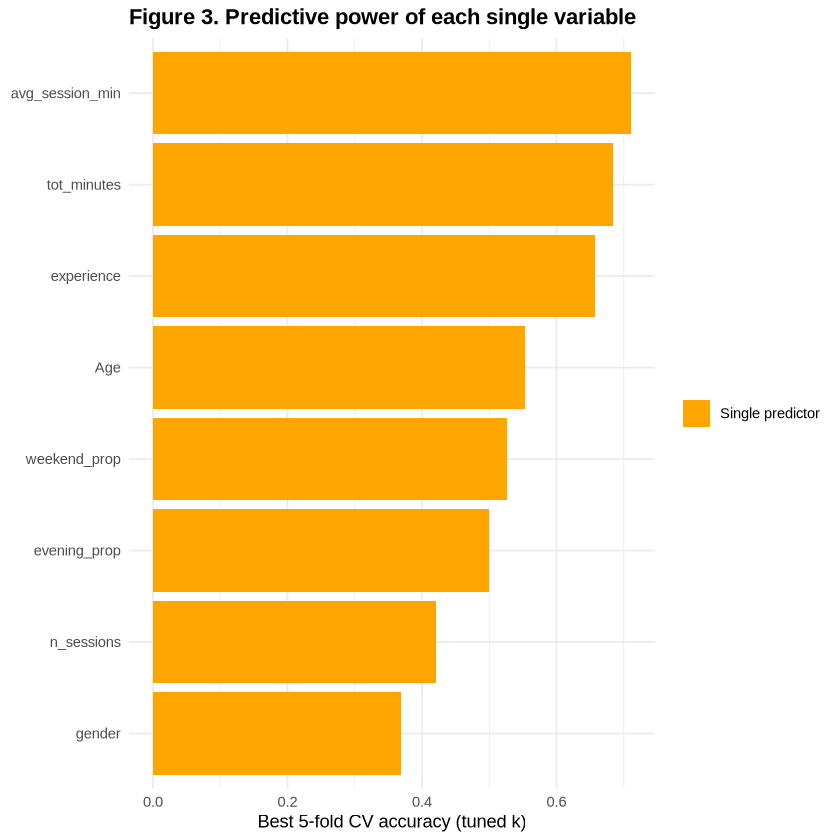

In [40]:
scores |>
  mutate(variable = fct_reorder(variable, accuracy)) %>% 
  ggplot(aes(accuracy, variable, fill = "Single predictor")) +
  geom_col() +
  scale_fill_manual(                                       
    name   = NULL,                                           
    values = c("Single predictor" = "orange")
  ) +
  labs(
    x     = "Best 5-fold CV accuracy (tuned k)",
    y     = NULL,
    title = "Figure 3. Predictive power of each single variable"
  ) +
  theme_minimal() +
  theme(
    plot.title      = element_text(face = "bold"),
    legend.position = "right"                                 
  )

To find the best subset of predictors, I adapted the textbook’s **forward selection algorithm** to our dataset. Forward selection starts with an empty model and adds predictors one at a time: at each step it tries every remaining variable, keeps the one that yields the highest cross-validated accuracy, and repeats until no further improvement is obtained (or all variables are used). In the code below I feed the algorithm our cleaned training set, use a k-NN specification with k tuned on a 5-fold CV grid at every step, and apply the same recipe pipeline. The result is a ranked list of models—size 1, size 2, …—each representing the best performing combination of that length, allowing us to pinpoint the point of diminishing returns and choose a most accurate predictor set.

In [41]:
set.seed(42)
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

k_grid    <- tibble(neighbors = seq(1, 25, by = 2))

names <- colnames(combined_data |> select(-subscribe, -hashedEmail, -name))
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("subscribe", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        cancer_recipe <- recipe(as.formula(model_string), data = train_data) |>
            step_impute_median(all_numeric_predictors()) |>
            step_normalize(all_numeric_predictors()) |>
            step_other(all_nominal_predictors(), threshold = 0.02) |>
            step_novel(all_nominal_predictors()) |>
            step_dummy(all_nominal_predictors(), one_hot = TRUE) |>
            step_zv(all_predictors())

        # tune the K-NN classifier with these predictors,
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(cancer_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = cancer_vfold, grid = k_grid) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
      add_row(size = i,
              model_string = models[[jstar]],
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies
# running this code takes some time (about 2~3 min)

size,model_string,accuracy
<int>,<chr>,<dbl>
1,subscribe ~ avg_session_min,0.7588235
2,subscribe ~ avg_session_min+weekend_prop,0.7705882
3,subscribe ~ avg_session_min+weekend_prop+tot_minutes,0.7705882
4,subscribe ~ avg_session_min+weekend_prop+tot_minutes+n_sessions,0.7705882
5,subscribe ~ avg_session_min+weekend_prop+tot_minutes+n_sessions+experience,0.7588235
6,subscribe ~ avg_session_min+weekend_prop+tot_minutes+n_sessions+experience+gender,0.7594771
7,subscribe ~ avg_session_min+weekend_prop+tot_minutes+n_sessions+experience+gender+Age,0.7594771
8,subscribe ~ avg_session_min+weekend_prop+tot_minutes+n_sessions+experience+gender+Age+evening_prop,0.7594771


The forward selection summary lists eight successive models, one for each subset size from 1 to 8 predictors.
Accuracy rises from 0.7588 for the single variable model (`avg_session_min` alone) to 0.7706 once `weekend_prop` is added (size 2). That accuracy remains **unchanged** when `tot_minutes` (size 3) and then `n_sessions` (size 4) are included. From size 5 onward, the reported accuracy drops back.

To see the change in accuracy clearly, I have coded the `accuracy` vs `# of predictor` plots, providing a visual summary of how performance changes as additional variables are added.

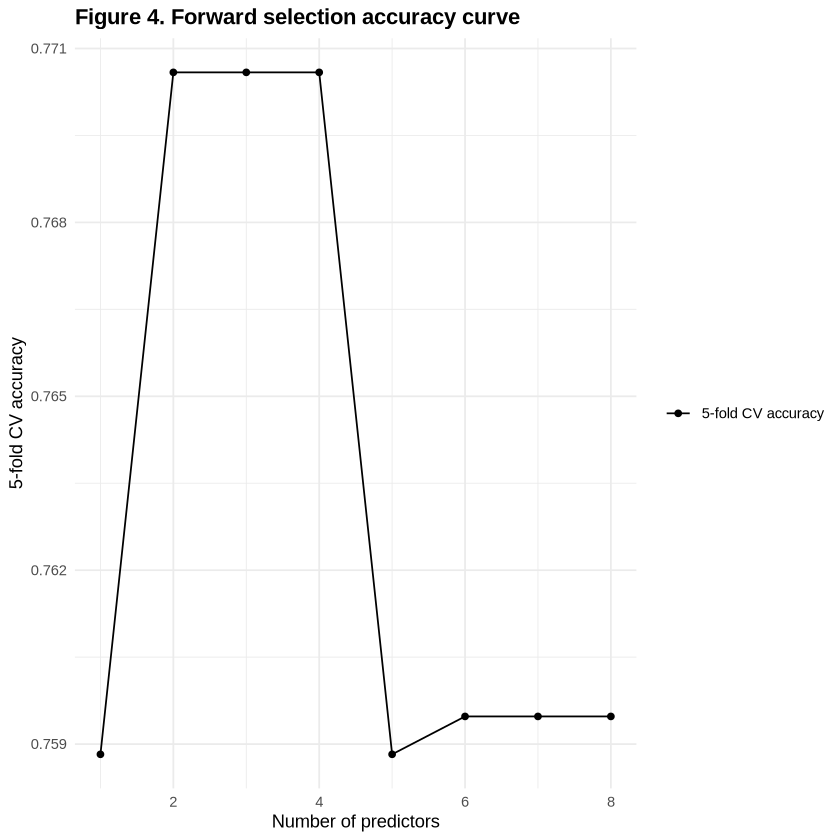

In [42]:
accuracies |>
  ggplot(aes(size, accuracy, colour = "5-fold CV accuracy")) + 
  geom_line() +
  geom_point() +
  scale_colour_manual(                                          
    name   = NULL,                                             
    values = c("5-fold CV accuracy" = "black")
  ) +
  labs(
    x     = "Number of predictors",
    y     = "5-fold CV accuracy",
    title = "Figure 4. Forward selection accuracy curve"
  ) +
  theme_minimal() +
  theme(
    plot.title      = element_text(face = "bold"),
    legend.position = "right"
  )

**Discussions**

As anticipated, `avg_session_min` emerged as the top-ranked single predictors, showing the highest cross-validated accuracies in the one variable screening phase. Because overall accuracy can hide the class imbalance, I also inspected the accompanying confusion matrices; the precision was noticeably lower than their headline accuracies, underscoring the need to evaluate more than one metric. Keeping that fact in mind, I moved on to multivariate modelling with forward selection.

Forward selection identified a two predictor model—`avg_session_min` + `weekend_prop`—that achieved the best 5-fold CV accuracy of 0.7706. The result is notable because `weekend_prop` on its own ranked only mid-pack, yet in combination with average session length it improved performance above any other combination we tried. Whether that lift reflects a genuine interaction or sampling noise will require further validation, but the model’s accuracy does clear the 0.73 baseline (the majority-class rule), so the pairing appears to add meaningful signal.

That said, the precision values for this two feature model remain modest, so the claim that these variables robustly predict subscription should be made **cautiously**. Future work should focus on boosting precision, perhaps through alternative algorithms.

Furthermore, the analysis naturally raises several **follow on questions**:

_First_, do interaction effects lurk beneath the surface? For example, does long average session length boost subscription probability even more for veteran players than for newcomers?

_Second_, the unexpected value of the weekend share prompts a closer look at finer time windows: are late Friday sessions more influential than Sunday afternoons?

_Third_, because precision remains modest, what are some ways to improve the precision?

In conclusion, engagement drives subscription: combining average session length with a player’s weekend play share raises predictive accuracy to roughly 77%, well above the 73 % baseline. While precision remains only moderate, this two feature model offers a clear, evidence based rule for identifying players most likely to opt in to the newsletter.

**Reference**

Timbers, T., Campbell, T., & Lee, M. _Data science: A first introduction_. https://datasciencebook.ca/